In [11]:
import json
import math
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from Bio import SeqIO
from augur.utils import json_to_tree
from scipy import stats

## Figure 5 supplemenmt: rate of amino acid substitution in all viruses

Plot the accumulation of mutations in the receptor-binding protein for all viruses in the panel

In [12]:
#read in colors from the manuscript_colors config file
color_config_json = f'config/manuscript_colors.json'
with open(color_config_json) as json_handle:
    colors = json.load(json_handle)

In [13]:
#path to the tree json files
tree_paths = {'sars2': '../sars2/auspice/ncov_gisaid_global_all-time.json', 
              'sars2_21L': '../sars2_21L/auspice/ncov_gisaid_21L_global_all-time.json', 
              'h3n2': "../seasonal-flu/auspice/flu_seasonal_h3n2_ha_60y.json", 
              'h1n1pdm': "../seasonal-flu/auspice/flu_seasonal_h1n1pdm_ha_12y.json", 
              'vic': "../seasonal-flu/new_builds/auspice/flu_seasonal_vic_ha_60y.json", 
              'yam': "../seasonal-flu/auspice/flu_seasonal_yam_ha_60y.json",
              'influenzaC_Yamagata': "../influenzaC/separate_lineages/auspice/fluC_HEF_Yamagata.json",
              '229e': "../seasonal-covs/229e/auspice/229e_S1.json", 
              'oc43_A': "../seasonal-covs/oc43/separate_lineages/auspice/seasonal_corona_oc43_a_s1.json", 
              'nl63': "../seasonal-covs/nl63/auspice/nl63_S1.json",
              'norovirus': "../norovirus/auspice/norovirus_GII.4_VP1.json", 
              'enterovirusd68': "../enterovirus_d68/genome/enterovirus_d68_genome.json", 
              'rsv_A': "../rsv/rsv_step3/auspice/rsv_A.json", 
              'rsv_B': "../rsv/rsv_step3/auspice/rsv_B.json", 
              'measles': "../measles/auspice/measles.json", 
              'mumps': "../mumps/auspice/mumps_na.json", 
              'parainfluenza_1': "../parainfluenza/auspice/parainfluenza_1.json", 
              'parainfluenza_3': "../parainfluenza/auspice/parainfluenza_3.json", 
              'dengue1_V': "../dengue/separate_genotypes/auspice/dengue_denv1_V.json",
              'dengue2_AA': "../dengue/separate_genotypes/auspice/dengue_denv2_AA.json",
              'dengue3_III': "../dengue/separate_genotypes/auspice/dengue_denv3_III.json",
              'dengue4_II': "../dengue/separate_genotypes/auspice/dengue_denv4_II.json",
              'rotavirusAg1p8':"../rotavirusA/auspice/rotavirusA_P_P[8].json", 
              'rotavirusAg1p4': "../rotavirusA/auspice/rotavirusA_P_P[4].json", 
              'hepatitisA_IA': "../hepatitisA/auspice/hepatitisA_IA.json", 
              'hepatitisB_D3': "../hepatitisB/hepatitisB_relativeToLarge/auspice/hepatitisB_D3.json", 
              'hepatitisB_A2': "../hepatitisB/hepatitisB_relativeToLarge/auspice/hepatitisB_A2.json",
              'adenovirusB7': "../adenovirusB/auspice/adenovirusB_7.json", 
              'adenovirusB3': "../adenovirusB/auspice/adenovirusB_3.json", 
              'parvovirusB19': "../parvovirusB19/auspice/parvovirusB19_1a.json"}


In [14]:
#name of RB protein
rb_protein = {'sars2':'S1', 'sars2_21L':'S1', 
              'h3n2': 'HA1', 'h1n1pdm': 'HA1', 'influenzaC_Yamagata': 'HEF1',
              'vic':'HA1', 'yam': 'HA1', 
              '229e': 'S1', 'oc43_A': 's1', 'nl63':'S1',
              'norovirus': "VP1", 'enterovirusd68': "VP1", 
              'rsv_A': "G", 'rsv_B': "G", 
              'measles': "H", 'mumps': "HN", 
              'parainfluenza_1':"HN", 'parainfluenza_3':"HN", 
              'dengue1_V': "E",'dengue2_AA': "E",'dengue3_III': "E",'dengue4_II': "E",
              'rotavirusAg1p8':"VP4", 'rotavirusAg1p4':"VP4", 
              'hepatitisA_IA': "VP1", 'hepatitisB_D3': "Large", 'hepatitisB_A2':"Large", 
              'adenovirusB7': "fiber", 'adenovirusB3': "fiber", 'parvovirusB19':"VP1"}

In [15]:
#length of RB protein, in codons/aas
rb_length = {'sars2':671, 'sars2_21L':671,
             'h3n2': 328, 'h1n1pdm': 326, 'vic':346, 'yam': 346, 'influenzaC_Yamagata':428,
             '229e': 544, 'oc43_A': 752, 'nl63':733,
             'norovirus': 540, 'enterovirusd68': 308, 
             'rsv_A': 321, 'rsv_B': 319, 
             'measles':617, 'mumps':582, 
             'parainfluenza_1':575, 'parainfluenza_3':572, 
             'dengue1_V': 494,'dengue2_AA': 494,'dengue3_III': 492,'dengue4_II': 494,
             'rotavirusAg1p8':776, 'rotavirusAg1p4':776, 
             'hepatitisA_IA':299, 'hepatitisB_D3':400, 'hepatitisB_A2':389,
             'adenovirusB7': 325, 'adenovirusB3':325, 'parvovirusB19':781}

In [16]:
def count_mutation_accumulation_on_tips(virus):
    """
    For each tip in the tree, find the nonsynonymous mutations in the receptor-binding protein 
    that have accumulated between the root of the tree and the tip
    """

    tree_file = tree_paths[virus]
    rb = rb_protein[virus]

    #read in the tree
    with open(tree_file, 'r') as f:
        tree_json = json.load(f)

    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)

    #initiate dictionary to keep track of the date and number of accumulated mutations for each tip on the tree
    aa_muts_over_time = []

    #get date of the root
    root_date = tree.root.node_attrs['num_date']['value']

    for node in tree.find_clades(terminal=True):
        path = tree.get_path(node)


        #count the number of amino acid mutations between root and tip
        #sars2 S1 is not labeled, instead will get S1 mutations from spike mutations (S1 is spike AAs 14-685)
        if virus in ['sars2', 'sars2_21L']:
            muts_in_spike = [x.branch_attrs['mutations']['S'] for x in path if 'S' in x.branch_attrs['mutations'].keys()]            
            muts_in_s1 = [[y for y in x if 14<=int(y[1:-1])<=685] for x in muts_in_spike]
            muts_in_s1_no_deletions = [[y for y in x if '-' not in y] for x in muts_in_s1]
            count_muts_in_s1 = sum([len(x) for x in muts_in_s1])
            count_muts_in_s1_no_deletions = sum([len(x) for x in muts_in_s1_no_deletions])
            muts_on_path = count_muts_in_s1_no_deletions
        #HEF1 also not labeled
        elif virus=='influenzaC_Yamagata':
            muts_in_hef = [x.branch_attrs['mutations']['FLUCVs4gp1'] for x in path if 'FLUCVs4gp1' in x.branch_attrs['mutations'].keys()]            
            muts_in_hef1 = [[y for y in x if 14<=int(y[1:-1])<=445] for x in muts_in_hef]
            muts_in_hef1_no_deletions = [[y for y in x if '-' not in y] for x in muts_in_hef1]
            count_muts_in_hef1 = sum([len(x) for x in muts_in_hef1])
            count_muts_in_hef1_no_deletions = sum([len(x) for x in muts_in_hef1_no_deletions])
            muts_on_path = count_muts_in_hef1_no_deletions
        else:
            muts_in_rb = sum([len(x.branch_attrs['mutations'][rb]) for x in path if rb in x.branch_attrs['mutations'].keys()])
            muts_in_rb_no_deletions = sum([len([y for y in x.branch_attrs['mutations'][rb] if '-' not in y]) for x in path if rb in x.branch_attrs['mutations'].keys()])
            muts_on_path = muts_in_rb_no_deletions

        muts_on_path_per_codon = muts_on_path/rb_length[virus]
        #get the date of this tip
        num_date = node.node_attrs['num_date']['value']
        #time between root and tip
        time = num_date - root_date

        aa_muts_over_time.append({'virus':virus, 'tip': node.name, 
                                  'date': num_date, 'time_from_root': time, 
                                  'aa_muts': muts_on_path, 'aa_muts_per_codon': muts_on_path_per_codon})

    df = pd.DataFrame(aa_muts_over_time)
    
    return df    
        

In [17]:
#legible virus names for plotting
virus_name_legible = {'sars2': 'SARS-CoV-2', 'sars2_21L': 'SARS-CoV-2, Omicron 21L',
                      'h3n2': 'Influenza A/H3N2', 'h1n1pdm': 'Influenza A/H1N1pdm', 
                      'vic':'Influenza B/Vic', 'yam': 'Influenza B/Yam', 
                      'influenzaC_Yamagata': 'Influenza C/Yamagata',
                      '229e': 'CoV 229E', 'oc43_A': 'CoV OC43-A', 'nl63': 'CoV NL63',
                      'norovirus': 'Norovirus GII.4', 'enterovirusd68': 'Enterovirus D68', 
                      'rsv_A': 'RSV-A', 'rsv_B': 'RSV-B', 'measles': 'Measles', 'mumps':'Mumps', 
                      'parainfluenza_1':'Parainfluenza-1', 'parainfluenza_3':'Parainfluenza-3',
                      'dengue1_V': 'Dengue 1-V','dengue2_AA': 'Dengue 2-AA',
                      'dengue3_III': 'Dengue 3-III','dengue4_II': 'Dengue 4-II', 
                      'rotavirusAg1p8':'Rotavirus A/P[8]', 'rotavirusAg1p4':'Rotavirus A/P[4]', 
                      'hepatitisA_IA': 'HepatitisA-IA', 
                      'hepatitisB_D3':'Hepatitis B-D3', 'hepatitisB_A2':'Hepatitis B-A2', 
                      'adenovirusB3': 'Adenovirus B-3', 'adenovirusB7': 'Adenovirus B-7', 
                      'parvovirusB19': 'Parvovirus B19-1A'}

In [18]:
#rate of amino acid subs over time for each virus
all_viruses = ['sars2', 'sars2_21L', 'h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC_Yamagata',
               '229e', 'oc43_A', 'nl63', 'enterovirusd68', 'norovirus',
               'rsv_A', 'rsv_B', 'measles', 'mumps', 
               'parainfluenza_1', 'parainfluenza_3', 
               'dengue1_V','dengue2_AA', 'dengue3_III','dengue4_II',
               'rotavirusAg1p4', 'rotavirusAg1p8', 'hepatitisA_IA', 
               'hepatitisB_D3', 'hepatitisB_A2', 'adenovirusB3', 'adenovirusB7', 'parvovirusB19']

aasub_data = {}
for virus in all_viruses:
    df = count_mutation_accumulation_on_tips(virus)
    aasub_data[virus] = df


In [19]:
# save rate of amino acid subs
viruses = ['adenovirusB3', 'adenovirusB7', 'parvovirusB19', 'hepatitisB_D3', 'hepatitisB_A2', 
                           'hepatitisA_IA', 'enterovirusd68', 'norovirus', 'rotavirusAg1p4', 'rotavirusAg1p8', 
                           'nl63', '229e', 'oc43_A', 'dengue1_V','dengue3_III','dengue4_II','dengue2_AA',
                           'parainfluenza_3', 'mumps', 'measles', 'parainfluenza_1', 'rsv_A', 'rsv_B', 
                           'influenzaC_Yamagata', 'yam', 'vic', 'h1n1pdm', 'h3n2']

aasubs_to_save = {}
for i in range(len(viruses)):
    virus = viruses[i]    

    #get subset of df relating to virus, with info about amino acid substitutions and time for each tip
    df = aasub_data[virus]
    #get linear fit
    coef = np.polyfit(df['date'], df['aa_muts_per_codon'], 1)
    poly1d_fn = np.poly1d(coef)
    #rate of amino acid substitution
    slope = coef[0]
    rate_aasubs = slope*10**3
    aasubs_to_save[virus] = rate_aasubs

json_object = json.dumps(aasubs_to_save, indent=4)
 
# Writing to sample.json
with open("adaptation_results/aasubrates.json", "w") as outfile:
    outfile.write(json_object)

In [20]:
#get the rate of adaptation for each virus
adaptation_rates = {}

for virus in all_viruses:
    window, min_seqs = 5, 3
    if virus in ['h1n1pdm', 'mumps']:
        window, min_seqs = 3, 3
    if 'dengue' in virus:
        virus_name = 'dengue_denv'+str(virus.split('dengue')[1])
    else:
        virus_name = virus
    if 'rotavirus' in virus:
        json_name = f'adaptation_results/results/{virus_name}_P_{window}_{min_seqs}_adaptation_bootstrapped.json'

    else:
        json_name = f'adaptation_results/results/{virus_name}_{rb_protein[virus]}_{window}_{min_seqs}_adaptation_bootstrapped.json'
    if path.exists(json_name):
        with open(json_name) as json_handle:
            json_dict = json.load(json_handle)
            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation, bootstrap_adaptive_substitutions, 
             bootstrap_adaptive_substitutions_per_codon, 
             bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

        bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)

        adaptation_rates[virus] = rate_of_adaptation* (10**3)

In [21]:
def plot_aasubs_vs_adaptation(viruses, filename=None):
    """
    For each virus, plot the rate of amino acid substitution vs the rate of adaptation in the receptor-binding protein
    """
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['figure.dpi']= 300
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5), gridspec_kw={'width_ratios':[3,5]})
    
    #keep track of rates for table
    info_for_table = []
    
    #add x=y line to scatterplot
    x = np.linspace(0, 6, 1000)
    ax2.plot(x, x, linestyle='--', color='#808080', zorder=1)
    #plot comparing of aa sub rate vs rate of adaptation
    for i in range(len(viruses)):
        virus = viruses[i]    
        
        #get subset of df relating to virus, with info about amino acid substitutions and time for each tip
        df = aasub_data[virus]
        #get linear fit
        coef = np.polyfit(df['date'], df['aa_muts_per_codon'], 1)
        poly1d_fn = np.poly1d(coef)
        #rate of amino acid substitution
        slope = coef[0]
        rate_aasubs = slope*10**3
        rate_aasubs_readable = f'{round(slope*10**3, 1)}'+'$ × 10^{-3}$ subs/res/year'
        
        #get rate of adaptation
        rate_adaptation = adaptation_rates[virus]
        
        subs_rate_for_table = round(rate_aasubs, 1)
        if subs_rate_for_table==-0.0:
            subs_rate_for_table = 0.0
        adaptation_rate_for_table = round(rate_adaptation,1)
        if adaptation_rate_for_table==-0.0:
            adaptation_rate_for_table=0.0
        info_for_table.append({'v': virus,'Virus':virus_name_legible[virus], 'Rate_AA_Subs': subs_rate_for_table, 
                               'Rate_Adaptation':adaptation_rate_for_table})
        
        #plot aa subs rate vs. rate of adaptation
        ax2.scatter(x=rate_aasubs, y=rate_adaptation, marker='o', s=80, color=colors['colors'][virus], 
                   edgecolor = colors['edge_colors'][virus])
    
    ax2.set_ylabel('Adaptive Muts per Codon per Year $(× 10^{-3})$')
    ax2.set_xlabel('Amino Acid Subs per Residue per Year $(× 10^{-3})$')
    
    #make a table by hand...
    df_for_table = pd.DataFrame(info_for_table)
    
    for row in range(len(info_for_table)):
        d = info_for_table[row]
        ax1.scatter(x=0.25, y=row, marker='o', color = colors['colors'][d['v']], 
                    edgecolor = colors['edge_colors'][d['v']])
        ax1.text(x=0.75, y=row, s=d['Virus'], va='center', ha='left', fontsize=7)
        ax1.text(x=4.25, y=row, s=d['Rate_AA_Subs'], va='center', ha='left', fontsize=8)
        ax1.text(x=5.75, y=row, s=d['Rate_Adaptation'], va='center', ha='left', fontsize=8)
        
    #column titles
    ax1.text(0, len(info_for_table)+0.75, 'Virus', weight='bold', ha='left')
    ax1.text(4.25, len(info_for_table)+0.75, 'Rate\nAA Subs\n$(× 10^{-3})$', weight='bold', ha='left', fontsize=7.5)
    ax1.text(5.75, len(info_for_table)+0.75, 'Rate\nAdaptation\n$(× 10^{-3})$', weight='bold', ha='left', fontsize=7.5)
    #line under column titles
    ax1.plot([0, 6.5], [len(info_for_table), len(info_for_table)], lw='.5', c='black')
    
#     ax1.set_ylim([0,len(info_for_table)+3])
    ax1.set_xlim([0,7])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['left'].set_color('white')
    ax1.spines['bottom'].set_color('white')
    
    panel_labels = {ax1:'A', ax2:'B'}
    for ax in [ax1, ax2]:
        ax.text(-0.02, 1.06, panel_labels[ax], horizontalalignment='center', 
                       verticalalignment='center', weight='bold', fontsize=14, transform=ax.transAxes)

            
        
    sns.despine()
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    
        

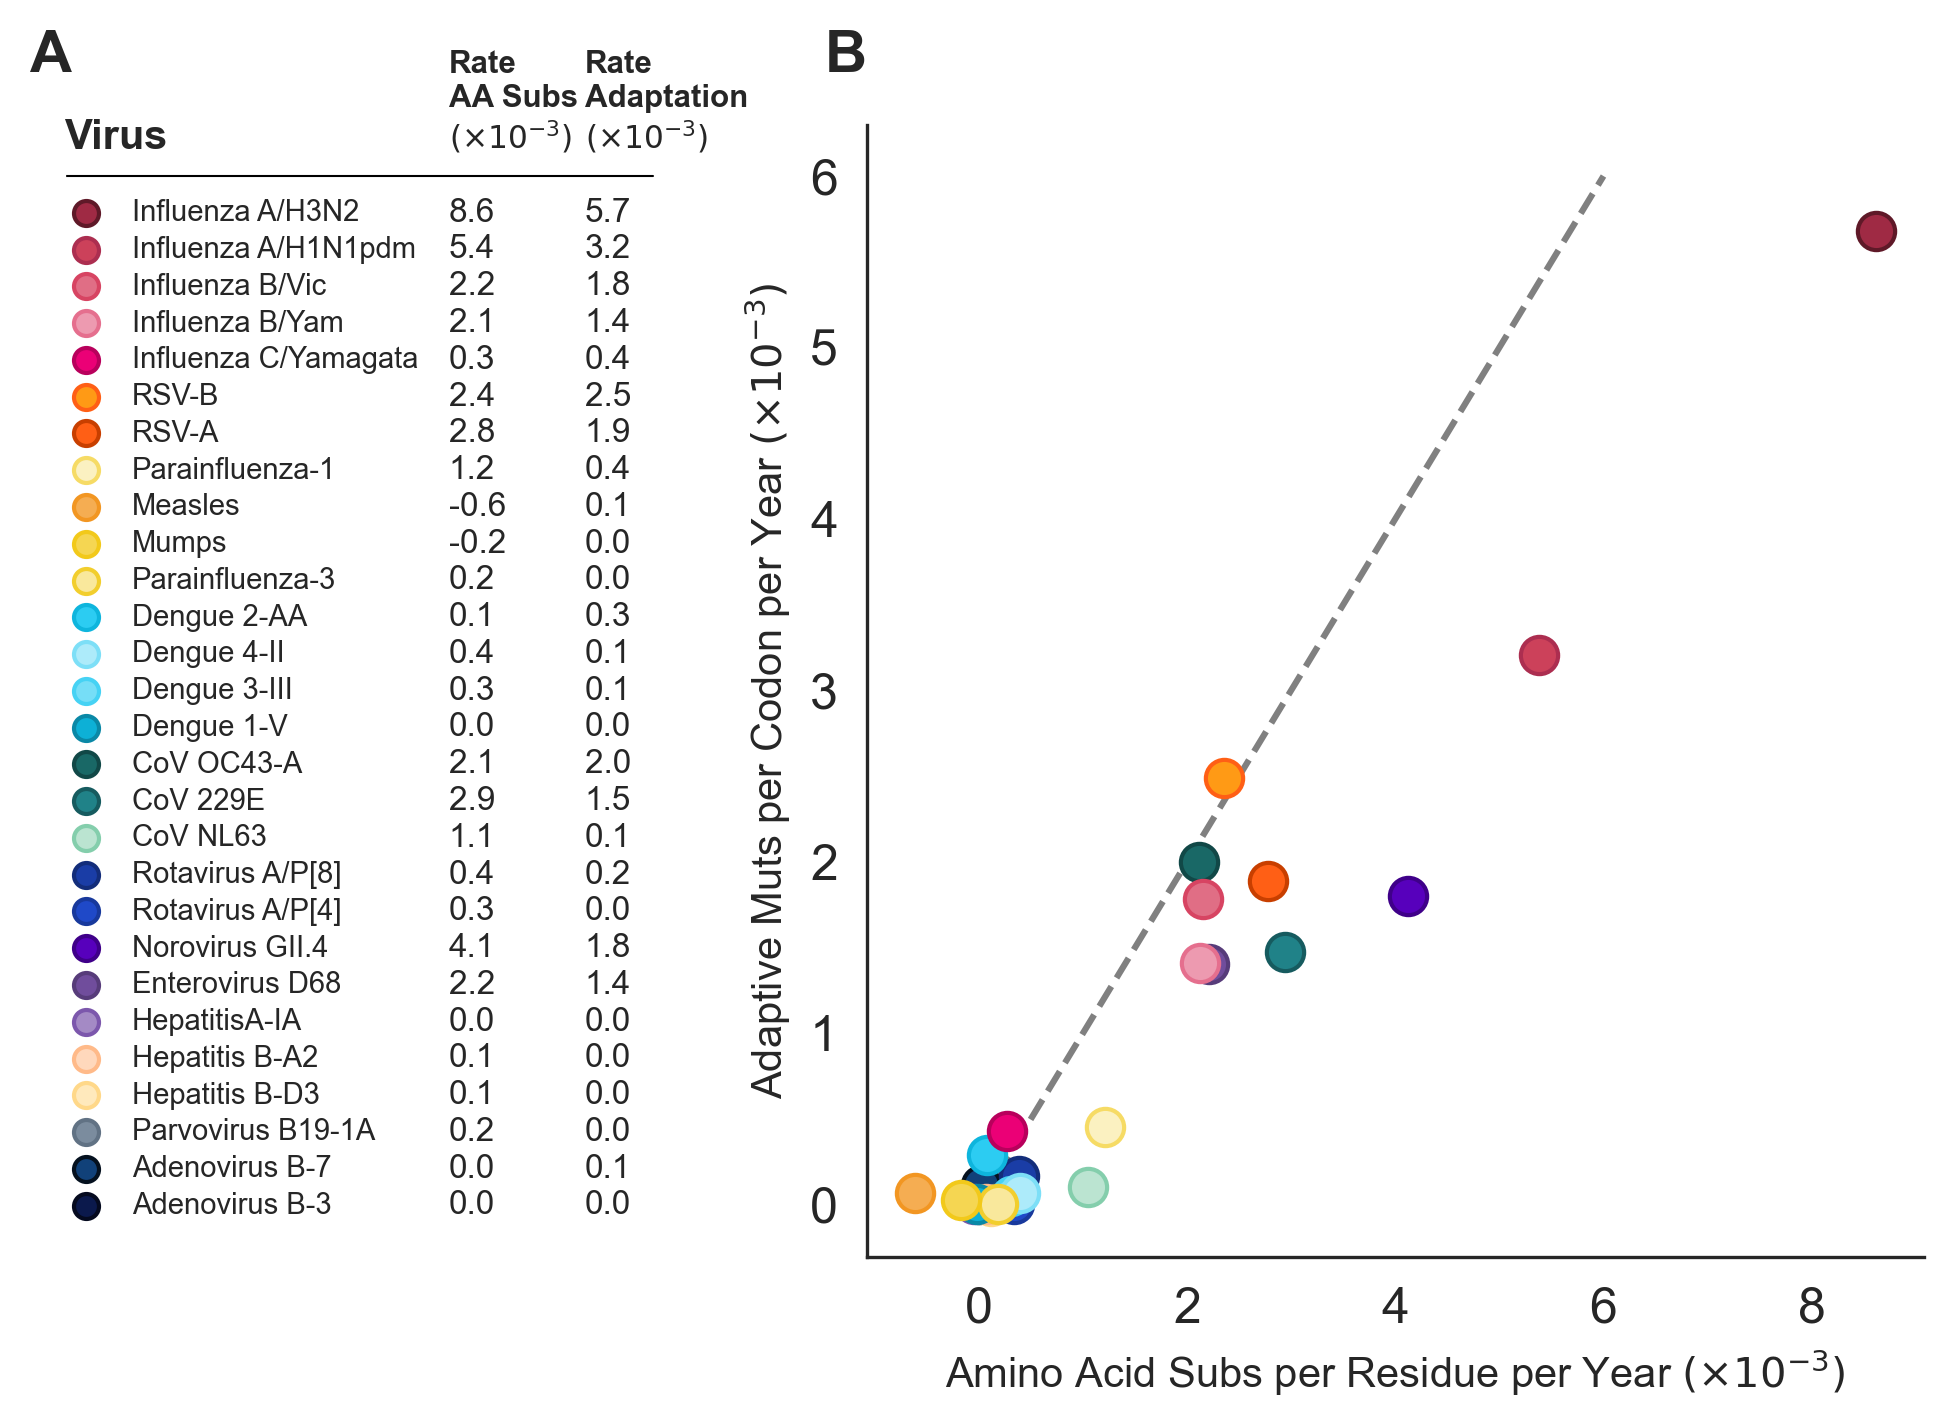

In [23]:
plot_aasubs_vs_adaptation(['adenovirusB3', 'adenovirusB7', 'parvovirusB19', 'hepatitisB_D3', 'hepatitisB_A2', 
                           'hepatitisA_IA', 'enterovirusd68', 'norovirus', 'rotavirusAg1p4', 'rotavirusAg1p8', 
                           'nl63', '229e', 'oc43_A', 'dengue1_V','dengue3_III','dengue4_II','dengue2_AA',
                           'parainfluenza_3', 'mumps', 'measles', 'parainfluenza_1', 'rsv_A', 'rsv_B', 
                           'influenzaC_Yamagata', 'yam', 'vic', 'h1n1pdm', 'h3n2'], 
                          filename= 'manuscript_figures/Supplement_SubsVsAdaptation.png')
